In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Dropout
from keras.utils import np_utils
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.constraints import max_norm
from keras.utils.vis_utils import plot_model
plt.rcParams['figure.figsize'] = (7,7)

In [2]:
def print_images(X_train, y_train):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(X_train[i].reshape(28,28), interpolation='none')
        plt.title("Class {}".format(y_train[i]))
    

In [3]:
def prepare_data(X_train,X_test,y_train,y_test):
    X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
    X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255    
    Y_train = np_utils.to_categorical(y_train, 10)
    Y_test = np_utils.to_categorical(y_test, 10)
    print_images(X_train, y_train)
    return X_train, X_test, Y_train, Y_test, y_test

In [4]:
def load_fresh_data():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    return prepare_data(X_train,X_test,y_train,y_test)

In [5]:
def get_noisy_data_2(noise_factor  = 0.25):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train, X_test, Y_train, Y_test, y_test = prepare_data(X_train,X_test,y_train,y_test)
    X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
    X_train_noisy = np.clip(X_train_noisy, 0., 1.)
    
    X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
    X_test_noisy = np.clip(X_test_noisy, 0., 1.)
    print_images(X_train_noisy, y_train)
    return X_train_noisy, X_test_noisy, Y_train, Y_test, y_test

In [6]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
def train_model(model, X_train, Y_train, epochs=4):
    model.fit(X_train, Y_train,
          batch_size=128, epochs=epochs,
         verbose=1,
          validation_data=(X_test, Y_test))
    return model

In [8]:
def predict_using_model(model, X_test, y_test):
    predicted_classes = model.predict_classes(X_test)
    correct_indices = np.nonzero(predicted_classes == y_test)[0]
    incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
    return predicted_classes, correct_indices, incorrect_indices

In [9]:
def plot_correct_and_incorrect(predicted_classes, correct_indices, incorrect_indices, y_test ):
    plt.figure()
    for i, correct in enumerate(correct_indices[:9]):
        plt.subplot(3,3,i+1)
        plt.imshow(X_test[correct].reshape(28,28), interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
    plt.figure()
    for i, incorrect in enumerate(incorrect_indices[:9]):
        plt.subplot(3,3,i+1)
        plt.imshow(X_test[incorrect].reshape(28,28), interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

## Using Auto Encorders To Denoise The Images

/home/ishamm/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


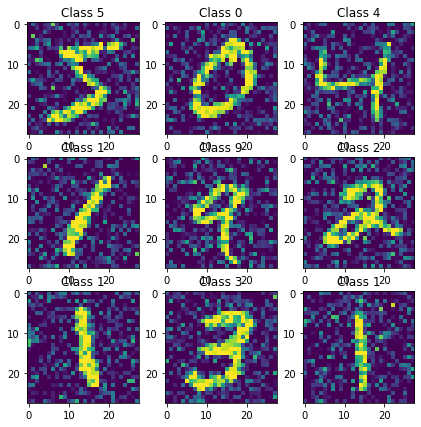

In [10]:
X_train, X_test, Y_train, Y_test, y_test = load_fresh_data()
X_train_noisy, X_test_noisy, Y_train, Y_test, y_test = get_noisy_data_2(noise_factor  = 0.25)

In [11]:
max_norm_value = 2.0

auto_encoder = Sequential()
auto_encoder.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=(28,28,1)))
auto_encoder.add(Conv2D(32, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
auto_encoder.add(Conv2DTranspose(32, kernel_size=(3,3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
auto_encoder.add(Conv2DTranspose(64, kernel_size=(3,3), kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
auto_encoder.add(Conv2D(1, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='sigmoid', padding='same'))

In [12]:
auto_encoder.summary()
plot_model(auto_encoder, to_file='model.png')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         577       
Total params: 47,425
Trainable params: 47,425
Non-trainable params: 0
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [13]:
auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')
auto_encoder.fit(X_train_noisy, X_train,
                epochs=4,
                batch_size=150,
                validation_split=0.2)

Epoch 1/4
320/320 [==============================] - 133s 415ms/step - loss: 0.0933 - val_loss: 0.0752
Epoch 2/4
320/320 [==============================] - 130s 406ms/step - loss: 0.0739 - val_loss: 0.0735
Epoch 3/4
320/320 [==============================] - 130s 407ms/step - loss: 0.0727 - val_loss: 0.0727
Epoch 4/4
320/320 [==============================] - 131s 409ms/step - loss: 0.0721 - val_loss: 0.0724


In [14]:
number_of_visualizations = 4
samples = X_test_noisy[:number_of_visualizations]
targets = X_test[:number_of_visualizations]
denoised_images = auto_encoder.predict(samples)

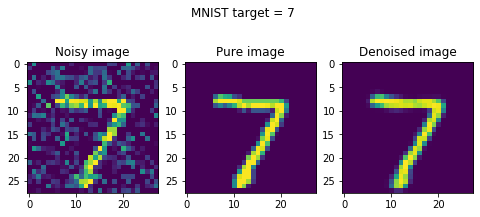

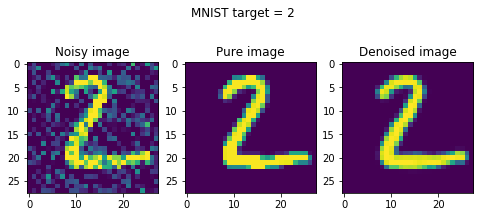

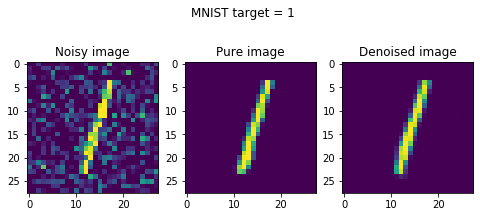

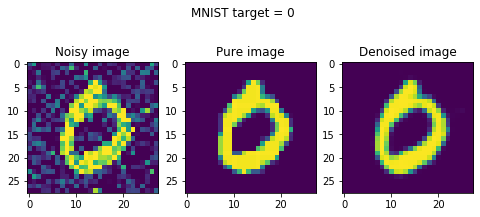

In [15]:
for i in range(0, number_of_visualizations):
  # Get the sample and the reconstruction
  noisy_image = X_test_noisy[i][:, :, 0]
  pure_image  = X_test[i][:, :, 0]
  denoised_image = denoised_images[i][:, :, 0]
  input_class = y_test[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(8, 3.5)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image')
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image')
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image')
  fig.suptitle(f'MNIST target = {input_class}')
  plt.show()

In [16]:
X_train_denoised =  auto_encoder.predict(X_train_noisy)
X_test_denoised =  auto_encoder.predict(X_test_noisy)

Epoch 1/4
469/469 [==============================] - 8s 17ms/step - loss: 0.2529 - accuracy: 0.9248 - val_loss: 0.1120 - val_accuracy: 0.9668
Epoch 2/4
469/469 [==============================] - 8s 17ms/step - loss: 0.1028 - accuracy: 0.9701 - val_loss: 0.0897 - val_accuracy: 0.9712
Epoch 3/4
469/469 [==============================] - 8s 17ms/step - loss: 0.0753 - accuracy: 0.9774 - val_loss: 0.0738 - val_accuracy: 0.9766
Epoch 4/4
469/469 [==============================] - 8s 17ms/step - loss: 0.0600 - accuracy: 0.9821 - val_loss: 0.0551 - val_accuracy: 0.9823
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Test Accuracy : 0.9801
Model: "sequential_1"
_____________________________________________________

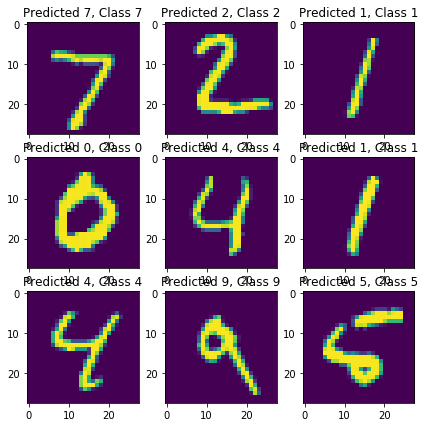

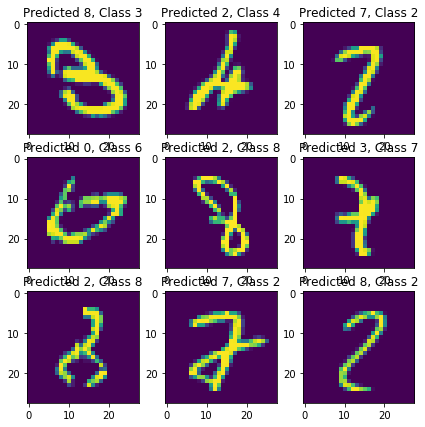

In [17]:
model = get_model()
model = train_model(model, X_train_denoised, Y_train)
predicted_classes, correct_indices, incorrect_indices = predict_using_model(model, X_test_denoised, y_test)
plot_correct_and_incorrect(predicted_classes, correct_indices, incorrect_indices, y_test )
print ("Test Accuracy : " + str(len(correct_indices)/(len(predicted_classes))))
model.summary()